# 1. pix2pix

In [1]:
import os
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
from PIL import Image
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.transforms.functional import center_crop
from torchvision.utils import make_grid
from tqdm.notebook import tqdm
import numpy as np
from itertools import chain

device = torch.device('cuda')

In [2]:
class FacadesDataset(Dataset):
    def __init__(self, path, target_size=None):
        self.base_path = path
        self.filenames = os.listdir(path)
        self.target_size = target_size

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]
        image = Image.open(os.path.join(self.base_path, filename))
        image = transforms.functional.to_tensor(image)
        image_width = image.shape[2]

        real = image[:, :, : image_width // 2]
        condition = image[:, :, image_width // 2 :]

        target_size = self.target_size
        if target_size:
            condition = nn.functional.interpolate(condition, size=target_size)
            real = nn.functional.interpolate(real, size=target_size)

        return real, condition

In [3]:
class ConvBatchReLUBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel=4, strides=2, padding=1, deconv=False, activation=True, batchnorm=True, dropout=False):
        super().__init__()
        self.activation = activation
        self.batchnorm = batchnorm
        self.dropout = dropout
        if deconv:
            self.conv = nn.ConvTranspose2d(in_channels, out_channels, kernel, strides, padding)
        else:
            self.conv = nn.Conv2d(in_channels, out_channels, kernel, strides, padding)

        if batchnorm:
            self.bn = nn.BatchNorm2d(out_channels)

        if activation:
            self.act = nn.ReLU()
        
        if dropout:
            self.drop = nn.Dropout2d(dropout)

    def forward(self, x):
        x = self.conv(x)
        if self.batchnorm:
            x = self.bn(x)
        if self.activation:
            x = self.act(x)
        if self.dropout:
            x = self.drop(x)
        return x

    
class Generator(nn.Module):
    def __init__(self, in_channels, out_channels, encoder_channels=[64, 128, 256, 512, 512, 512, 512]):
        super().__init__()
        self.encoders = []
        for i in range(len(encoder_channels)):
            if i == 0:
                encoder_block = ConvBatchReLUBlock(in_channels, encoder_channels[i], batchnorm=False)
            elif i == len(encoder_channels) - 1:
                encoder_block = ConvBatchReLUBlock(encoder_channels[i-1], encoder_channels[i], batchnorm=False)
            else:
                encoder_block = ConvBatchReLUBlock(encoder_channels[i-1], encoder_channels[i])
            self.encoders.append(encoder_block)
            
        self.decoders = []
        decoder_channels = encoder_channels[::-1]
        for i in range(1, len(decoder_channels)):
            if i == 1:
                decoder_block = ConvBatchReLUBlock(decoder_channels[i-1], decoder_channels[i], deconv=True)
            else:
                decoder_block = ConvBatchReLUBlock(decoder_channels[i-1]*2, decoder_channels[i], deconv=True)
            self.decoders.append(decoder_block)

        self.output_deconv = nn.ConvTranspose2d(decoder_channels[-1], out_channels, kernel_size=4, stride=2, padding=1)
        self.tanh = nn.Tanh()

        self.encoders = nn.ModuleList(self.encoders)
        self.decoders = nn.ModuleList(self.decoders)

    def forward(self, x):
        skips_cons = []
        for encoder in self.encoders:
            x = encoder(x)
            skips_cons.append(x)

        skips_cons = list(reversed(skips_cons[:-1]))
        decoders = self.decoders[:-1]

        for decoder, skip in zip(decoders, skips_cons):
            x = decoder(x)
            x = torch.cat((x, skip), axis=1)

        x = self.decoders[-1](x)
        x = self.output_deconv(x)
        return self.tanh(x)

In [4]:
class Discriminator(nn.Module):
    def __init__(self, input_channels):
        super().__init__()
        self.model = nn.Sequential(
            ConvBatchReLUBlock(input_channels, 64, batchnorm=False, dropout=0.1),
            ConvBatchReLUBlock(64, 128, dropout=0.1),
            ConvBatchReLUBlock(128, 256, dropout=0.1),
            ConvBatchReLUBlock(256, 512, dropout=0.1),
            nn.Conv2d(512, 1, kernel_size=1)
        )

    def forward(self, x, y):
        x = torch.cat([x, y], axis=1)
        x = self.model(x)
        return x

In [5]:
def display_progress(cond, fake, real, figsize=(10,5)):
    cond = cond.detach().cpu().permute(1, 2, 0)
    fake = fake.detach().cpu().permute(1, 2, 0)
    real = real.detach().cpu().permute(1, 2, 0)
    
    fig, ax = plt.subplots(1, 3, figsize=figsize)
    ax[0].imshow(torch.clip(cond, 0, 1))
    ax[2].imshow(torch.clip(fake, 0, 1))
    ax[1].imshow(torch.clip(real, 0, 1))
    plt.show()

In [6]:
class Pix2Pix(nn.Module):
    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=200):
        super().__init__()
        self.generator = Generator(in_channels, out_channels)
        self.generator.to(device)
        self.discriminator = Discriminator(in_channels + out_channels)
        self.discriminator.to(device)
        
        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()
        
        self.generator_opt = torch.optim.Adam(self.generator.parameters(), lr=learning_rate)
        self.discriminator_opt = torch.optim.Adam(self.discriminator.parameters(), lr=learning_rate)
        
        self.lambda_recon = lambda_recon
        
    def train(self, batch):
        self.generator.train()
        self.discriminator.train()
        
        real_images, conditioned_images = batch
        real_images = real_images.to(device)
        conditioned_images = conditioned_images.to(device)
        
        fake_images = self.generator(conditioned_images)
        disc_logits = self.discriminator(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        recon_loss = self.recon_criterion(fake_images, real_images)

        generator_loss = adversarial_loss + self.lambda_recon * recon_loss
        self.generator_opt.zero_grad()
        generator_loss.backward()
        self.generator_opt.step()
        
        fake_images = self.generator(conditioned_images).detach()
        fake_logits = self.discriminator(fake_images, conditioned_images)
        real_logits = self.discriminator(real_images, conditioned_images)
        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        
        discriminator_loss = (real_loss + fake_loss) / 2
        self.discriminator_opt.zero_grad()
        discriminator_loss.backward()
        self.discriminator_opt.step()
        
        return generator_loss.cpu().item(), discriminator_loss.cpu().item()
    
    def evaluate(self, batch):
        self.generator.eval()
        self.discriminator.eval()
        
        real_images, conditioned_images = batch
        real_images = real_images.to(device)
        conditioned_images = conditioned_images.to(device)
        
        fake_images = self.generator(conditioned_images)
        disc_logits = self.discriminator(fake_images, conditioned_images)
        adversarial_loss = self.adversarial_criterion(disc_logits, torch.ones_like(disc_logits))

        recon_loss = self.recon_criterion(fake_images, real_images)

        generator_loss = adversarial_loss + self.lambda_recon * recon_loss
        
        fake_images = self.generator(conditioned_images).detach()
        fake_logits = self.discriminator(fake_images, conditioned_images)
        real_logits = self.discriminator(real_images, conditioned_images)
        fake_loss = self.adversarial_criterion(fake_logits, torch.zeros_like(fake_logits))
        real_loss = self.adversarial_criterion(real_logits, torch.ones_like(real_logits))
        
        discriminator_loss = (real_loss + fake_loss) / 2

        return generator_loss.cpu().item(), discriminator_loss.cpu().item()
    
    def generate(self, batch):
        self.generator.eval()
        self.discriminator.eval()
        
        real_images, conditioned_images = batch
        real_images = real_images.to(device)
        conditioned_images = conditioned_images.to(device)
        
        with torch.no_grad():
            fake_images = self.generator(conditioned_images)
        
        return real_images, conditioned_images, fake_images

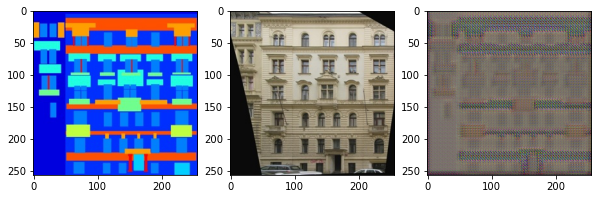

Epoch:   0, TRAIN:  GEN 69.26 DISC 0.55    VAL:  GEN 47.03 DISC 0.81
Epoch:   1, TRAIN:  GEN 45.66 DISC 0.26    VAL:  GEN 41.11 DISC 0.94
Epoch:   2, TRAIN:  GEN 42.03 DISC 0.18    VAL:  GEN 37.37 DISC 0.94
Epoch:   3, TRAIN:  GEN 41.03 DISC 0.12    VAL:  GEN 37.13 DISC 0.92
Epoch:   4, TRAIN:  GEN 39.94 DISC 0.07    VAL:  GEN 35.89 DISC 0.79


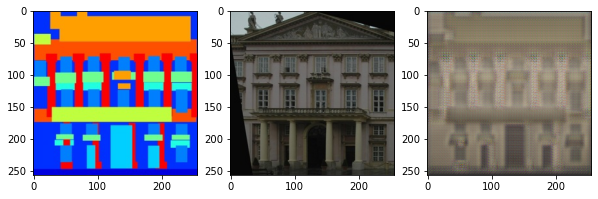

Epoch:   5, TRAIN:  GEN 39.61 DISC 0.05    VAL:  GEN 36.39 DISC 0.81
Epoch:   6, TRAIN:  GEN 39.40 DISC 0.04    VAL:  GEN 35.55 DISC 0.80
Epoch:   7, TRAIN:  GEN 39.16 DISC 0.03    VAL:  GEN 36.84 DISC 0.75
Epoch:   8, TRAIN:  GEN 39.43 DISC 0.02    VAL:  GEN 36.18 DISC 0.72
Epoch:   9, TRAIN:  GEN 39.10 DISC 0.02    VAL:  GEN 36.17 DISC 0.83


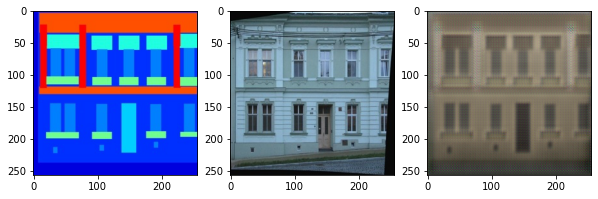

Epoch:  10, TRAIN:  GEN 38.92 DISC 0.02    VAL:  GEN 35.35 DISC 0.85
Epoch:  11, TRAIN:  GEN 38.80 DISC 0.10    VAL:  GEN 37.95 DISC 1.52
Epoch:  12, TRAIN:  GEN 37.95 DISC 0.37    VAL:  GEN 37.49 DISC 0.86
Epoch:  13, TRAIN:  GEN 38.77 DISC 0.29    VAL:  GEN 39.51 DISC 0.63
Epoch:  14, TRAIN:  GEN 37.45 DISC 0.34    VAL:  GEN 40.55 DISC 0.87


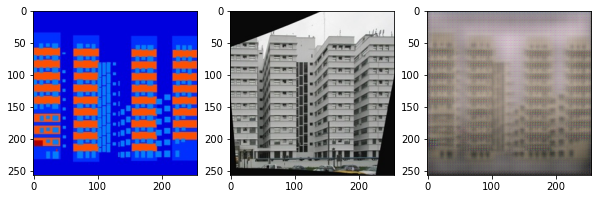

Epoch:  15, TRAIN:  GEN 35.84 DISC 0.30    VAL:  GEN 37.43 DISC 0.87
Epoch:  16, TRAIN:  GEN 35.25 DISC 0.28    VAL:  GEN 38.43 DISC 0.99
Epoch:  17, TRAIN:  GEN 34.01 DISC 0.55    VAL:  GEN 36.74 DISC 0.84
Epoch:  18, TRAIN:  GEN 32.62 DISC 0.56    VAL:  GEN 35.72 DISC 0.84
Epoch:  19, TRAIN:  GEN 31.91 DISC 0.51    VAL:  GEN 36.04 DISC 0.68


In [7]:
lambda_recon = 200
n_epochs = 20
batch_size = 16
lr = 3e-4
target_size = 256
show_each = 5

train = FacadesDataset('data/facades/train', target_size=target_size)
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
val = FacadesDataset('data/facades/val', target_size=target_size)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True)

pix2pix = Pix2Pix(3, 3, learning_rate=lr, lambda_recon=lambda_recon)
for i in range(n_epochs):
    train_gen_loss = []
    train_disc_loss = []
    val_gen_loss = []
    val_disc_loss = []
    for batch in train_dataloader:
        gen_loss, disc_loss = pix2pix.train(batch)
        train_gen_loss.append(gen_loss)
        train_disc_loss.append(disc_loss)
    
    for batch in val_dataloader:
        gen_loss, disc_loss = pix2pix.evaluate(batch)
        val_gen_loss.append(gen_loss)
        val_disc_loss.append(disc_loss)
    
    if i % show_each == 0:
        real_images, conditioned_images, fake_images = pix2pix.generate(batch)
        display_progress(conditioned_images[0], fake_images[0], real_images[0])
        
    print(f'Epoch: {i:3}, TRAIN:  GEN {np.mean(train_gen_loss):4.2f} DISC {np.mean(train_disc_loss):4.2f}    VAL:  GEN {np.mean(val_gen_loss):4.2f} DISC {np.mean(val_disc_loss):4.2f}')

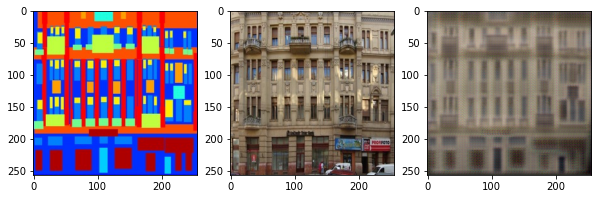

In [10]:
real_images, conditioned_images, fake_images = pix2pix.generate(batch)
display_progress(conditioned_images[-1], fake_images[-1], real_images[-1])

По итогу выглядит достаточно неплохо, хоть и размыто.  
В целом pix2pix чему-то, да научился :)

# 2. CycleGAN

In [7]:
class CycleGAN(nn.Module):
    def __init__(self, in_channels, out_channels, learning_rate=0.0002, lambda_recon=200):
        super().__init__()
        self.generator_A = Generator(in_channels, out_channels)
        self.generator_A.to(device)
        self.discriminator_A = Discriminator(in_channels + out_channels)
        self.discriminator_A.to(device)
        
        self.generator_B = Generator(out_channels, in_channels)
        self.generator_B.to(device)
        self.discriminator_B = Discriminator(in_channels + out_channels)
        self.discriminator_B.to(device)
        
        self.adversarial_criterion = nn.BCEWithLogitsLoss()
        self.recon_criterion = nn.L1Loss()
        
        self.generator_opt = torch.optim.Adam(chain(self.generator_A.parameters(), self.generator_B.parameters()), lr=learning_rate)
        self.discriminator_opt = torch.optim.Adam(chain(self.discriminator_A.parameters(), self.discriminator_B.parameters()), lr=learning_rate)
        
        self.lambda_recon = lambda_recon

        
    def train(self, batch):
        self.generator_A.train()
        self.generator_B.train()
        self.discriminator_A.eval()
        self.discriminator_B.eval()
        
        y, x = batch # real_images, conditioned_images = batch
        real_a = x.to(device)
        real_b = y.to(device)
        # a -> x, b -> y
        fake_b = self.generator_A(real_a)
        rec_a = self.generator_B(fake_b)
        fake_a = self.generator_B(real_b)
        rec_b = self.generator_A(fake_a)
        
        loss_idt_A = self.recon_criterion(fake_b, real_b) * lambda_recon
        loss_idt_B = self.recon_criterion(fake_a, real_a) * lambda_recon
        
        disc_A_logits = self.discriminator_A(fake_b, real_a).detach()
        loss_G_A = self.adversarial_criterion(disc_A_logits, torch.ones_like(disc_A_logits))
        
        disc_B_logits = self.discriminator_B(fake_a, real_b).detach()
        loss_G_B = self.adversarial_criterion(disc_B_logits, torch.ones_like(disc_B_logits))
        
        loss_cycle_A = self.recon_criterion(rec_a, real_a) * lambda_recon
        loss_cycle_B = self.recon_criterion(rec_b, real_b) * lambda_recon
        
        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
        
        self.generator_opt.zero_grad()
        loss_G.backward()
        self.generator_opt.step()
        
        self.generator_A.eval()
        self.generator_B.eval()
        self.discriminator_A.train()
        self.discriminator_B.train()
        
        fake_b = self.generator_A(real_a).detach()
        fake_a = self.generator_B(real_b).detach()
        
        fake_logits_A = self.discriminator_A(fake_b, real_a)
        real_logits_A = self.discriminator_A(real_b, real_a)
        fake_loss_A = self.adversarial_criterion(fake_logits_A, torch.zeros_like(fake_logits_A))
        real_loss_A = self.adversarial_criterion(real_logits_A, torch.ones_like(real_logits_A))
        discriminator_A_loss = (real_loss_A + fake_loss_A) / 2
        
        fake_logits_B = self.discriminator_B(fake_a, real_b)
        real_logits_B = self.discriminator_B(real_a, real_b)
        fake_loss_B = self.adversarial_criterion(fake_logits_B, torch.zeros_like(fake_logits_B))
        real_loss_B = self.adversarial_criterion(real_logits_B, torch.ones_like(real_logits_B))
        discriminator_B_loss = (real_loss_B + fake_loss_B) / 2
 
        self.discriminator_opt.zero_grad()
        discriminator_A_loss.backward()
        discriminator_B_loss.backward()   
        self.discriminator_opt.step()

        return loss_G.cpu().item(), discriminator_A_loss.cpu().item(), discriminator_B_loss.cpu().item()
        
    def evaluate(self, batch):
        self.generator_A.eval()
        self.generator_B.eval()
        self.discriminator_A.eval()
        self.discriminator_B.eval()
        
        y, x = batch # real_images, conditioned_images = batch
        real_a = x.to(device)
        real_b = y.to(device)
        # a -> x, b -> y
        fake_b = self.generator_A(real_a)
        rec_a = self.generator_B(fake_b)
        fake_a = self.generator_B(real_b)
        rec_b = self.generator_A(fake_a)
        
        loss_idt_A = self.recon_criterion(fake_b, real_b) * lambda_recon * 0.5
        loss_idt_B = self.recon_criterion(fake_a, real_a) * lambda_recon * 0.5
        
        disc_A_logits = self.discriminator_A(fake_b, real_a)
        loss_G_A = self.adversarial_criterion(disc_A_logits, torch.ones_like(disc_A_logits))
        
        disc_B_logits = self.discriminator_B(fake_a, real_b)
        loss_G_B = self.adversarial_criterion(disc_B_logits, torch.ones_like(disc_B_logits))
        
        loss_cycle_A = self.recon_criterion(rec_a, real_a) * lambda_recon
        loss_cycle_B = self.recon_criterion(rec_b, real_b) * lambda_recon
        
        loss_G = loss_G_A + loss_G_B + loss_cycle_A + loss_cycle_B + loss_idt_A + loss_idt_B
        
        fake_b = self.generator_A(real_a).detach()
        fake_a = self.generator_B(real_b).detach()
        
        fake_logits_A = self.discriminator_A(fake_b, real_a)
        real_logits_A = self.discriminator_A(real_b, real_a)
        fake_loss_A = self.adversarial_criterion(fake_logits_A, torch.zeros_like(fake_logits_A))
        real_loss_A = self.adversarial_criterion(real_logits_A, torch.ones_like(real_logits_A))
        discriminator_A_loss = (real_loss_A + fake_loss_A) / 2
        
        fake_logits_B = self.discriminator_B(fake_a, real_b)
        real_logits_B = self.discriminator_B(real_a, real_b)
        fake_loss_B = self.adversarial_criterion(fake_logits_B, torch.zeros_like(fake_logits_B))
        real_loss_B = self.adversarial_criterion(real_logits_B, torch.ones_like(real_logits_B))
        discriminator_B_loss = (real_loss_B + fake_loss_B) / 2

        return loss_G.cpu().item(), discriminator_A_loss.cpu().item(), discriminator_B_loss.cpu().item()
    
    def generate(self, batch):
        self.generator_A.eval()
        self.generator_B.eval()
        self.discriminator_A.eval()
        self.discriminator_B.eval()
        
        real_images, conditioned_images = batch
        real_images = real_images.to(device)
        conditioned_images = conditioned_images.to(device)
        
        with torch.no_grad():
            fake_images = self.generator_A(conditioned_images)
        
        return real_images, conditioned_images, fake_images

  0%|          | 0/100 [00:00<?, ?it/s]

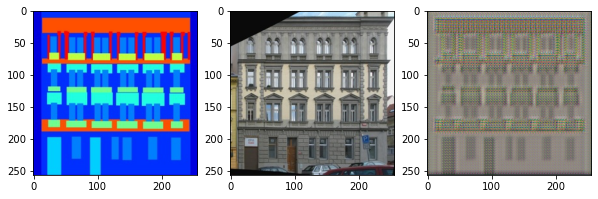

Epoch:   0, TRAIN:  GEN 10.78 DISC 0.55 0.51   VAL:  GEN 5.74 DISC 0.94 0.88


  0%|          | 0/100 [00:00<?, ?it/s]

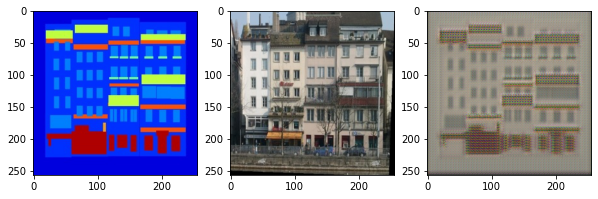

Epoch:   1, TRAIN:  GEN 7.20 DISC 0.22 0.18   VAL:  GEN 5.21 DISC 0.91 1.12


  0%|          | 0/100 [00:00<?, ?it/s]

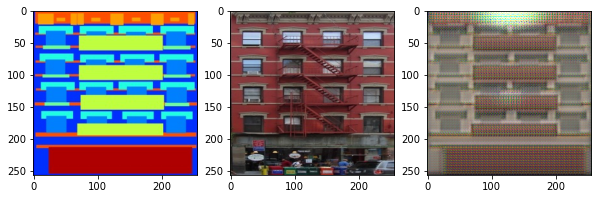

Epoch:   2, TRAIN:  GEN 6.60 DISC 0.11 0.11   VAL:  GEN 4.76 DISC 1.13 1.04


  0%|          | 0/100 [00:00<?, ?it/s]

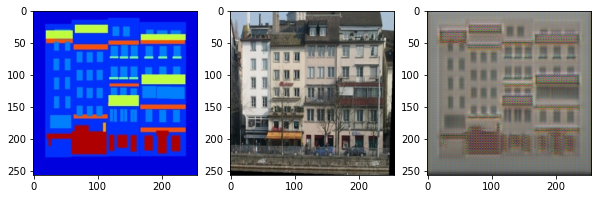

Epoch:   3, TRAIN:  GEN 6.46 DISC 0.06 0.07   VAL:  GEN 5.49 DISC 0.88 0.78


  0%|          | 0/100 [00:00<?, ?it/s]

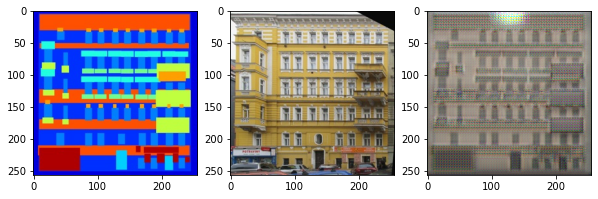

Epoch:   4, TRAIN:  GEN 6.22 DISC 0.04 0.05   VAL:  GEN 4.52 DISC 0.86 1.09


  0%|          | 0/100 [00:00<?, ?it/s]

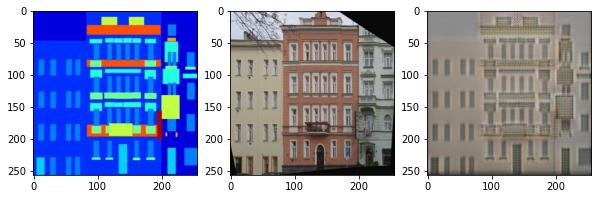

Epoch:   5, TRAIN:  GEN 6.14 DISC 0.03 0.02   VAL:  GEN 4.18 DISC 0.97 1.24


  0%|          | 0/100 [00:00<?, ?it/s]

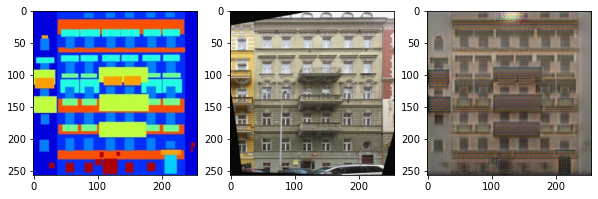

Epoch:   6, TRAIN:  GEN 5.89 DISC 0.03 0.03   VAL:  GEN 4.46 DISC 0.80 1.00


  0%|          | 0/100 [00:00<?, ?it/s]

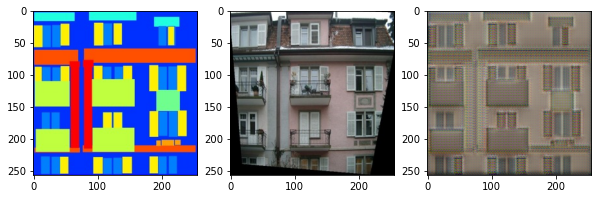

Epoch:   7, TRAIN:  GEN 5.90 DISC 0.02 0.02   VAL:  GEN 4.47 DISC 0.86 0.90


  0%|          | 0/100 [00:00<?, ?it/s]

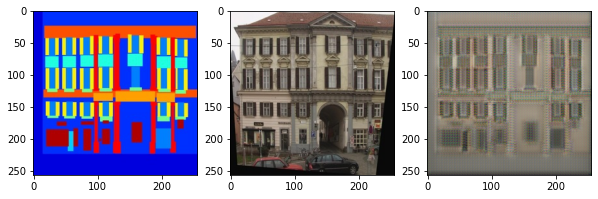

Epoch:   8, TRAIN:  GEN 5.85 DISC 0.01 0.02   VAL:  GEN 4.27 DISC 0.82 1.21


  0%|          | 0/100 [00:00<?, ?it/s]

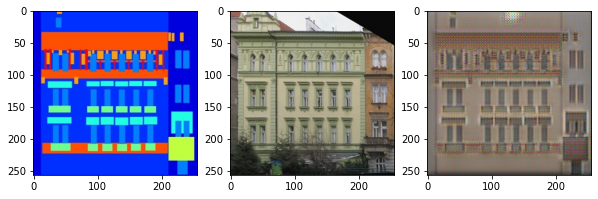

Epoch:   9, TRAIN:  GEN 5.98 DISC 0.01 0.04   VAL:  GEN 4.38 DISC 0.84 1.06


  0%|          | 0/100 [00:00<?, ?it/s]

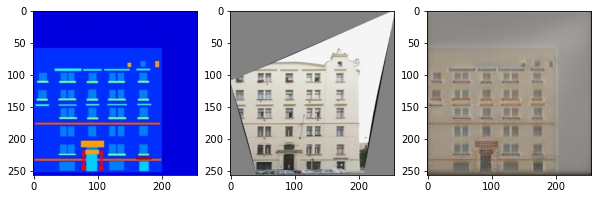

Epoch:  10, TRAIN:  GEN 5.74 DISC 0.02 0.02   VAL:  GEN 4.26 DISC 0.83 0.93


  0%|          | 0/100 [00:00<?, ?it/s]

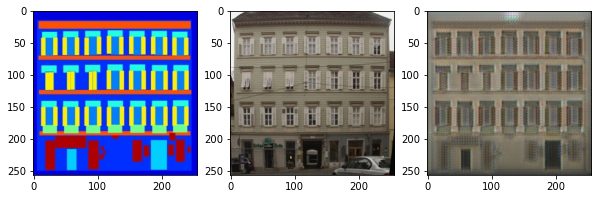

Epoch:  11, TRAIN:  GEN 5.34 DISC 0.03 0.01   VAL:  GEN 3.64 DISC 0.97 1.25


  0%|          | 0/100 [00:00<?, ?it/s]

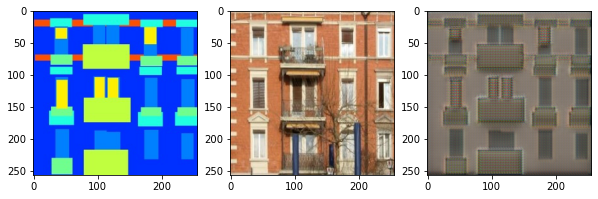

Epoch:  12, TRAIN:  GEN 5.31 DISC 0.01 0.01   VAL:  GEN 4.09 DISC 0.94 0.93


  0%|          | 0/100 [00:00<?, ?it/s]

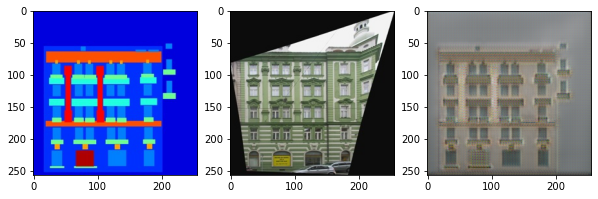

Epoch:  13, TRAIN:  GEN 5.40 DISC 0.01 0.01   VAL:  GEN 3.60 DISC 0.96 1.08


  0%|          | 0/100 [00:00<?, ?it/s]

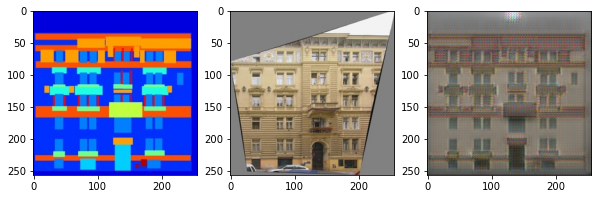

Epoch:  14, TRAIN:  GEN 5.26 DISC 0.01 0.01   VAL:  GEN 4.08 DISC 0.88 0.78


  0%|          | 0/100 [00:00<?, ?it/s]

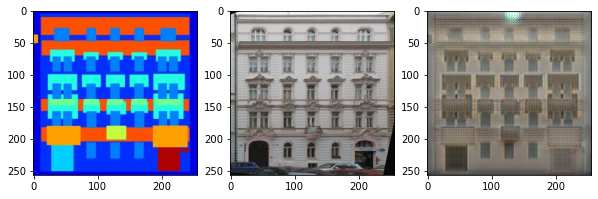

Epoch:  15, TRAIN:  GEN 5.57 DISC 0.04 0.01   VAL:  GEN 4.20 DISC 0.98 0.92


  0%|          | 0/100 [00:00<?, ?it/s]

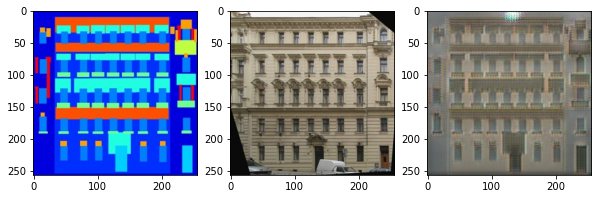

Epoch:  16, TRAIN:  GEN 5.46 DISC 0.01 0.01   VAL:  GEN 4.36 DISC 0.94 0.79


  0%|          | 0/100 [00:00<?, ?it/s]

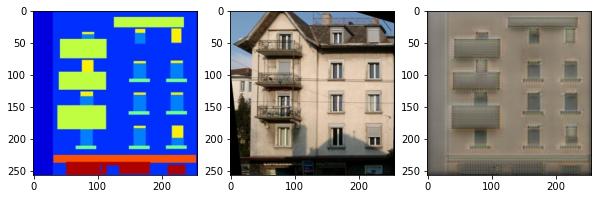

Epoch:  17, TRAIN:  GEN 5.52 DISC 0.00 0.02   VAL:  GEN 3.84 DISC 0.89 1.07


  0%|          | 0/100 [00:00<?, ?it/s]

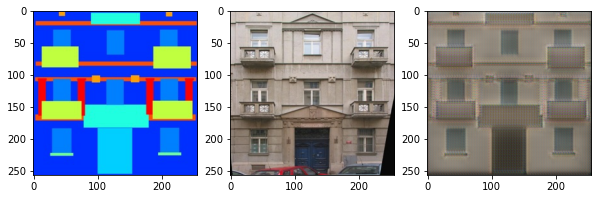

Epoch:  18, TRAIN:  GEN 5.36 DISC 0.00 0.01   VAL:  GEN 3.98 DISC 0.82 0.97


  0%|          | 0/100 [00:00<?, ?it/s]

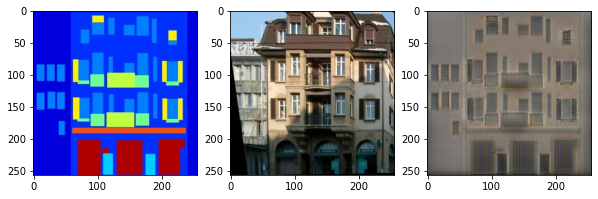

Epoch:  19, TRAIN:  GEN 4.87 DISC 0.01 0.01   VAL:  GEN 3.61 DISC 0.99 0.88


In [8]:
lambda_recon = 10
n_epochs = 20
batch_size = 4
lr = 2e-4
target_size = 256
show_each = 5

train = FacadesDataset('data/facades/train', target_size=target_size)
train_dataloader = DataLoader(train, batch_size=batch_size, shuffle=True)
val = FacadesDataset('data/facades/val', target_size=target_size)
val_dataloader = DataLoader(val, batch_size=batch_size, shuffle=True)

cyclegan = CycleGAN(3, 3, learning_rate=lr, lambda_recon=lambda_recon)
for i in range(n_epochs):
    train_gen_loss = []
    train_discA_loss = []
    train_discB_loss = []
    val_gen_loss = []
    val_discA_loss = []
    val_discB_loss = []
    for batch in tqdm(train_dataloader):
        gen_loss, discA_loss, discB_loss = cyclegan.train(batch)
        train_gen_loss.append(gen_loss)
        train_discA_loss.append(discA_loss)
        train_discB_loss.append(discB_loss)
    
    for batch in val_dataloader:
        gen_loss, discA_loss, discB_loss = cyclegan.evaluate(batch)
        val_gen_loss.append(gen_loss)
        val_discA_loss.append(discA_loss)
        val_discB_loss.append(discB_loss)
    
    # if i % show_each == 0:
    real_images, conditioned_images, fake_images = cyclegan.generate(batch)
    display_progress(conditioned_images[0], fake_images[0], real_images[0])
        
    print(f'Epoch: {i:3}, TRAIN:  GEN {np.mean(train_gen_loss):4.2f} DISC {np.mean(train_discA_loss):4.2f} {np.mean(train_discB_loss):4.2f}   VAL:  GEN {np.mean(val_gen_loss):4.2f} DISC {np.mean(val_discA_loss):4.2f} {np.mean(val_discB_loss):4.2f}')

Лоссы падают, значит, сеть хоть чему-то учится, изображения становятся все лучше и лучше (хоть и подбирал архитектуру и параметры по статье, правда там было больше эпох обучения).
Возможно, стоило бы обучить больше времени, но видеокарта очень уж сильно греется :)  
Спасибо за курс!!!